# Clinical Trials Data Processing

## Goal

- To get a basic data processing pipeline outlined 
- To get the results we need to build a MVP 
- To understand future steps for more advanced study p

## TODOS
- Compare results filtering with the number of results from the GUI
- Parse all studies into workable CSVs with certain attributes 
- Create a safe method for getting values from the JSON file withought killin the study 
- Add in objective flags for measurement types
- Get the P-Values with the other types
- Add in the demographics to the csv
- Look at the missed values and see if the studies are really missing data 


In [1]:
# I think we just need to get all the studies and filter out the ones with results manually 
# We can make a module for this later
# The conditions can be easily parsed but we need to bucket them -> maybe make a model for that??
# The demographics are the easiest to get out of this
# Effectiveness - this can be done by averaging the difference between placebo and results, thought we 
# first have to filter the studies that have a placebo 
#
# Fields to be 

In [111]:
import requests
import pandas as pd
import scipy.stats as stats 
import nltk
import seaborn as sns
import numpy as np

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG='gabapentin'

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Interfacing with ClinicalTrials.gov
- TODO: need to get all the studies not just the ones in a certain range 
- It's also worth noting that we can download all of this data

In [4]:
# First a basic API interface

def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()

def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()

In [5]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies


## Conditions

### Consolidate the Conditions Data

- Need to get all the conditions in a formatted dataframe to parse the other results

- TODO: the AncestorConditions are too broad and the normal conditions are too specific -> we need our own 
method for this


In [27]:
raw_conditions_dict = get_conditions_for_drug('gabapentin') 

In [28]:
condition_field_values = raw_conditions_dict['FieldValuesResponse']['FieldValues']

In [29]:
parsable = {'Conditions': [], 'NStudies': []}
for value in condition_field_values:
    parsable['Conditions'].append(value['FieldValue'])
    parsable['NStudies'].append(value['NStudiesFoundWithValue'])

conditionsDf = pd.DataFrame.from_dict(parsable).sort_values('NStudies', ascending=False)
conditionsDf

,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
...,...,...
120,Infertility,1
121,"Infertility, Male",1
122,Inflammatory Bowel Diseases,1
123,Intellectual Disability,1


### Exploratory Statistics 
- Let's get a better feel for the conditions here 

In [30]:
conditionsDf.head(20)


,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
150,Mental Disorders,82
213,Postoperative Complications,68
207,Peripheral Nervous System Diseases,62
160,Musculoskeletal Diseases,44
246,Sleep Wake Disorders,40


<AxesSubplot:>

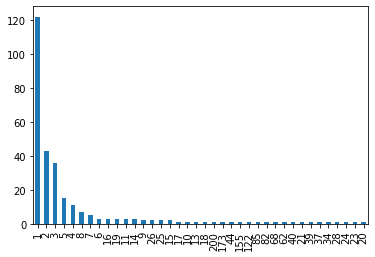

In [31]:
import matplotlib.pyplot as plt

conditionsDf['NStudies'].value_counts().plot.bar()

In [32]:
# We need to get a cutoff value for what conditions are going to be listed 
# The value should be percentage based to account for the differing study values for each drug
# Maybe the conditions that add up to 50% of the data or something 
# Actually let's just take top 5 - this is a problem for the medical people

conditionsDf.sum()['NStudies']

2189

In [33]:
count = 0
curr_sum = 0
total_sum = conditionsDf.sum()['NStudies']
for i in range(len(conditionsDf)):
    if curr_sum / total_sum > .1:
        break
    
    curr_sum += conditionsDf['NStudies'][i]
    count += 1


## Study Processing

- Filter out useless studies san results 
- Parse out useful values from the tree: place
- Create a dataframe for the other aspects of drug 

In [6]:
# Get all studies for all conditions for a given drug
# studies = []
# for condition in conditionsDf[0:3]['Conditions'].tolist():
#     print(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
#     studies += get_all_studies(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
    

### Parsing data
- Need to reduce the attrition rate for all the studies
- Let's get all the following into a csv -> a function for each

In [7]:
# Get all studies relating to the example drug 
studies = get_all_studies(EXAMPLE_DRUG)
len(studies)

112

### Create Tables
- Studies
- Groups
- Outcomes
- Measures

We need a good relational model to analyze this data fully

In [8]:
def create_studies_table(studies):
    buffer = {
        'study_id': [], 'name': [], 'drug': [], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'type': [], 'description': [],
        'interventions': []
              
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(EXAMPLE_DRUG)
        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo']['DesignInterventionModel'])
        except KeyError as e:
            buffer['type'].append('NA')
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
    
    return buffer
studies_df = pd.DataFrame.from_dict(create_studies_table(studies))
studies_df.head()

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,"This is a randomized, placebo-controlled, cros...",[Gabapentin]
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,The purpose of this study is to prospectively ...,[Gabapentin]
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,Patients aged 10-19 years with idiopathic scol...,[Gabapentin]
3,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,Subject must carry a diagnosis of fibromyalgia...,[Gabapentin]
4,NCT00578552,Gabapentin for Smoking Abstinence,gabapentin,"[Cigarette Smoking, Tobacco Use]",April 2011,"{'ResponsiblePartyOldNameTitle': 'Amit Sood, M...",Parallel Assignment,A total of 120 participants will be recruited ...,[Gabapentin]


In [9]:
studies_df[studies_df['interventions'].apply(len) == 0]

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions
86,NCT01426230,"A Phase 4, Open Label, Study of Safety and Eff...",gabapentin,[Post Herpetic Neuralgia],March 2013,{'ResponsiblePartyType': 'Sponsor'},NA,"Open Label, single arm, 2wk titration, 6 wk st...",[]
90,NCT01332305,"A Randomized, Double-Blind, Placebo-Controlled...",gabapentin,[Restless Legs Syndrome],May 2011,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,"This was a multicenter, randomized, double bli...",[]
105,NCT02186795,Improvement in Total Hip Arthroplasty Patient ...,gabapentin,"[Arthroplasty, Replacement, Hip, Arthritis]",June 2018,{'ResponsiblePartyType': 'Principal Investigat...,NA,Primary outcome: 48 hour opiate consumption in...,[]
107,NCT00404248,Phase I/II Study of Intravenous Infusion of Te...,gabapentin,[Brain and Central Nervous System Tumors],March 2019,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,OBJECTIVES:\n\nPrimary\n\nDetermine the maximu...,[]
109,NCT03975790,Comparative Analysis of Outcomes Among Patient...,gabapentin,[Rheumatoid Arthritis],September 2019,{'ResponsiblePartyType': 'Sponsor'},NA,NA,[]


#### Groups Table
The control or placebo group that gets nothing 
- Name
- Study
- Id
- Number of participants 
- Description

In [10]:
def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        for group in groups:

            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription'))
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
    
    return groups_df, parts
        
groups = pd.DataFrame.from_dict(create_groups_table(studies)[0])
groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


#### Measures Table
- Study Id
- title
- Type 
- Description
- Disperision param
- Measure Param
- Units

In [11]:
def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules

def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 

measures = pd.DataFrame.from_dict(create_measures_table(studies)).drop_duplicates(['study_id', 'measure'])
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [12]:
measures[measures['type'] == 'Primary']['units'].value_counts()

participants                      73
Participants                      52
units on a scale                  29
score on a scale                  11
Units on a scale                   8
                                  ..
TOTAL DOSE OF MEPERIDINE, mg       1
µg/mL                              1
mg/day x 5 days                    1
logMAR                             1
percentage of total sleep time     1
Name: units, Length: 77, dtype: int64

#### Outcomes Table
- Study_id
- Group_id
- Type
- Title
- Measure
- Unit
- Time
- Dispersion
- Upper 
- Lower
- Value 


In [13]:
'''
We need to create disjoint tables :( 
'''
    
# def make_outcomes_map(measure):
#     mp = {}
#     for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
#         mp['classTitle'] = group.get('OutcomeClassTitle', 'NA')
        
#         for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
#             for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
#                 mp[outcome['OutcomeMeasurementGroupId']] = outcome
#     return mp
                
                
def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                                
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_id'].append(outcome.get('OutcomeMeasurementGroupId', 'NA'))
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)
        
admin_df, outcome_df = create_outcomes_table(studies)
administrations = pd.DataFrame.from_dict(admin_df)
outcomes = pd.DataFrame.from_dict(outcome_df)

In [14]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 2,3.5,NA,4.5,2.6,46
1,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 2,3.4,NA,4.4,2.5,49
2,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 4,5.4,NA,6.5,4.3,28
3,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 4,5.5,NA,6.7,4.3,25
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 6,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...
6572,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,29.9,1.7,16
6573,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,30.0,1.7,26
6574,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,NA,9.0,8.0,NA,NA,10
6575,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,NA,9.8,8.4,NA,NA,16


In [15]:
administrations

,study_id,group_id,measure,title,description
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...
...,...,...,...,...,...
2186,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...
2187,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...
2188,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.
2189,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...


In [16]:
# Now we actually need to add in the doses
# This is going to be tricky as the groups have sepperate doses
#Put it all together
units_map = {
    'milligram': 'mg',
    'kilogram': 'kg',
    'gram': 'g'
            }
def clean_doses_map(doses_map, hitlist):
    units = []
    nums_map = {}
    for num in doses_map:
        unit = []
        for word in doses_map[num]:
            if word in hitlist:
                unit.append(units_map[word] if word in units_map else word)
            elif '/' in word:
                unit.append('/'.join(filter(lambda x: x in hitlist, word.split('/'))))
        nums_map[num] = ''.join(unit).replace('per', '/')
    return nums_map

def check_trailings_for_measures(trailings, hitlist):
    mask = []
    for trailing in trailings:
        flag = False
        for word in trailing:
            if (word in hitlist) or ('/' in word):
                flag = True
        mask.append(flag)

    return mask

def get_nums_trailings(trailings, nums, hitlist):
    mask = check_trailings_for_measures(trailings, hitlist)
    return {nums[i]:trailings[i] for i in range(len(nums)) if mask[i]}
        
doses_hit_list = ['mg', 'g', 'kg', 'milligram', 'kilogram', 'gram', 'per']
doses_hit_list += [x+'/' for x in doses_hit_list]

stemmer = nltk.stem.PorterStemmer()
def apply_to_nested_list(nested_list, func):
    for i, lst in enumerate(nested_list):
        lst = [func(x) for x in lst]
        nested_list[i] = lst
    return nested_list

def get_numbers(string):
    nums= []
    curr_num= []
    for char in string:
        if char.isdigit():
            curr_num.append(char)
        elif curr_num:
            nums.append(int(''.join(curr_num)))
            curr_num = []
            
    return nums

def get_trailing_words(string, nums):
    trailings = []
    for num in nums:
        trailings.append([x.replace('.', '').replace('(','').replace(')','') for x in string.split(str(num))[1].split()[0:3]])
    return trailings

def get_doses(string): #Typically the string is the description
    nums = get_numbers(string)
    trailings = get_trailing_words(string, nums)
    stemmed = apply_to_nested_list(trailings, stemmer.stem)
    return clean_doses_map(get_nums_trailings(stemmed, nums, doses_hit_list), doses_hit_list)
    

administrations['dose'] = administrations['description'].apply(get_doses)
administrations

,study_id,group_id,measure,title,description,dose
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,{}
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...,{}
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
...,...,...,...,...,...,...
2186,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,{}
2187,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...,{}
2188,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.,{}
2189,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,{}


### Create Statistics 
- This is an interesting task because some of the studies have their own stats which we probably want to trust??

We need to bubble up the stats from the bottom, this means that each measure needs it's own results, then
we can interperate all the results on a higher level with the study

Generally we need some stats rows for each measure since we need to retrieve the ones that may or may not be a part of
the study

#### Stats table 
- Get the analysis from the existing measures if there is any 

In [17]:
def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df

analytics = pd.DataFrame.from_dict(create_analytics_table(studies))
analytics

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
...,...,...,...,...,...,...,...,...,...
1957,NCT01524796,Change From Baseline In Worst Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1958,NCT01524796,Change From Baseline In Least Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1959,NCT00667342,Mean Ktrans,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'}
1960,NCT00667342,Mean Vp,[OG000],NA,Logistic Regression,NA,True,0.0573,{'OG000': 'A: Localized Resectable Disease'}


In [18]:
analytics['study_id'].value_counts()

NCT03975790    669
NCT01236053    382
NCT00385671    326
NCT01138124     80
NCT03179345     71
              ... 
NCT01262092      1
NCT00619983      1
NCT01632215      1
NCT02725710      1
NCT00617461      1
Name: study_id, Length: 64, dtype: int64

In [19]:
def find_placebo_groups(title):
    words = [''.join([char for char in word if char.isalpha()]).lower() for word in title.split()]
    return 'placebo' in words or 'control' in words

def find_drug_groups(title):
    return EXAMPLE_DRUG.lower() in title.lower()


In [20]:
# Need to merge with outcomes and measures 

comp_admin = administrations[administrations['title'].apply(find_drug_groups)]
control_admin = administrations[administrations['title'].apply(find_placebo_groups)]


In [21]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 2,3.5,NA,4.5,2.6,46
1,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 2,3.4,NA,4.4,2.5,49
2,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 4,5.4,NA,6.5,4.3,28
3,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 4,5.5,NA,6.7,4.3,25
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 6,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...
6572,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,29.9,1.7,16
6573,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,30.0,1.7,26
6574,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,NA,9.0,8.0,NA,NA,10
6575,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,NA,9.8,8.4,NA,NA,16


In [22]:
measures

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg
...,...,...,...,...,...,...,...
904,NCT00667342,Number of Participants With Neuropathic Pain (...,Other Pre-specified,"Of the 43 participants enrolled on this trial,...",NA,Number,participants
905,NCT00667342,Median Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks
906,NCT00667342,Mean Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Standard Deviation,Mean,Weeks
907,NCT00667342,Median Duration of Neuropathic Pain Medication,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks


In [23]:
working_measures = measures.merge(
    control_admin, 'left', ['study_id', 'measure']).merge(
    comp_admin, 'left', ['study_id', 'measure'])
working_measures = working_measures.fillna('NA')
working_measures = working_measures[(working_measures['group_id_x'] != 'NA') & (working_measures['group_id_y'] != 'NA')]
working_measures

,study_id,measure,type,description_x,dispersion_param,measure_param,units,group_id_x,title_x,description_y,dose_x,group_id_y,title_y,description,dose_y
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,{},OG000,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,{},OG000,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,NCT01868425,Impact of Block Characteristics on Pain Control,Secondary,NA,NA,NA,NA,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
696,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
697,NCT01868425,Intraoperative Medication Use: Fentanyl,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mcg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
698,NCT01868425,Number of Participants With Complications From...,Secondary,NA,NA,Count of Participants,Participants,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}


In [24]:

big_kahuna = working_measures.rename(columns={'group_id_x': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id']).rename(columns = {
    'title_x': 'control_title', 
    'description_y': 'control_description', 
    'group_id': 'control_group_id',
    'value': 'control_value',
    'dispersion': 'control_dispersion',
    'upper': 'control_upper',
    'lower': 'control_lower',
    'dose_x': 'control_dose',
    'participants': 'control_participants',
    'group_id_y': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id', 'title']).rename(columns={
    'value': 'drug_value',
    'dispersion': 'drug_dispersion',
    'upper': 'drug_upper',
    'lower': 'drug_lower',
    'participants': 'drug_participants',
    'group_id': 'drug_group_id'
}).fillna(value='NA')
big_kahuna

,study_id,measure,type,description_x,dispersion_param,measure_param,units,control_group_id,control_title,control_description,...,control_value,control_dispersion,control_upper,control_lower,control_participants,drug_value,drug_dispersion,drug_upper,drug_lower,drug_participants
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,3.4,NA,4.4,2.5,49,3.5,NA,4.5,2.6,46
3,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,5.5,NA,6.7,4.3,25,5.4,NA,6.5,4.3,28
4,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,5.8,NA,7.1,4.4,19,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,65.6,36.9,NA,NA,57,71.5,28.4,NA,NA,55
925,NCT01868425,Intraoperative Medication Use: Fentanyl,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mcg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,128,81.8,NA,NA,57,125,64.4,NA,NA,55
926,NCT01868425,Number of Participants With Complications From...,Secondary,NA,NA,Count of Participants,Participants,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,0,NA,NA,NA,57,0,NA,NA,NA,55
927,NCT01868425,Time to Discharge,Secondary,Time to discharge from the recovery room (Phas...,Standard Deviation,Mean,minutes,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,61.4,19.5,NA,NA,57,64.8,17.7,NA,NA,55


In [25]:
list(big_kahuna.columns)

['study_id',
 'measure',
 'type',
 'description_x',
 'dispersion_param',
 'measure_param',
 'units',
 'control_group_id',
 'control_title',
 'control_description',
 'control_dose',
 'drug_group_id',
 'title_y',
 'description',
 'dose_y',
 'title',
 'control_value',
 'control_dispersion',
 'control_upper',
 'control_lower',
 'control_participants',
 'drug_value',
 'drug_dispersion',
 'drug_upper',
 'drug_lower',
 'drug_participants']

In [26]:
import math 

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e:
        return -1
    
    return -1

def get_pval(row):
    mean1 = float(row.control_value) if row.control_value != 'NA' else -1
    ranges1 = row.control_dispersion if row.control_dispersion != 'NA' else (row.control_lower, row.control_upper)
    nobs1 = int(row.control_participants) if row.control_participants != 'NA' else -1
    
    mean2 = float(row.drug_value) if row.drug_value != 'NA' else -1
    ranges2 = row.drug_dispersion if row.drug_dispersion != 'NA' else (row.drug_lower, row.drug_upper)
    nobs2 = int(row.drug_participants) if row.drug_participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    std2 = get_sd(row.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

p_vals = pd.Series(big_kahuna.apply(lambda x: get_pval(x), axis=1))
big_kahuna['p_vals_derived'] = p_vals

Jesus fucking christ what is with all the -1s!!! 

Might have messed up the merge - unsure 

<AxesSubplot:>

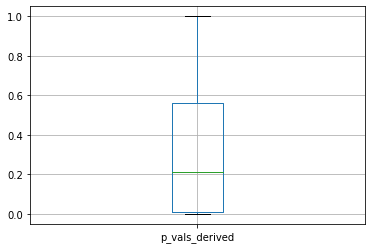

In [27]:
big_kahuna[big_kahuna['p_vals_derived'] != -1].boxplot(column=['p_vals_derived'])

In [28]:
# Make our own stats rows
base = big_kahuna[['study_id', 'measure', 'title', 'measure_param', 'p_vals_derived']]
base['groups'] = pd.Series([[x[0], x[1]] for x in zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['control_group_id'].tolist())])
base['fromStudy'] = pd.Series([False for x in range(len(big_kahuna['drug_group_id'].tolist()))])
base['group_titles'] = pd.Series([dict([x[0], x[1]]) for x in zip(zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['title_y'].tolist()), zip(big_kahuna['control_group_id'].tolist(), big_kahuna['control_title'].tolist()))])
base['method'] = pd.Series(['t-test' for x in range(len(big_kahuna['drug_group_id'].tolist()))])
new_analytics = base.rename(columns={
    'title': 'description',
    'measure_param': 'param_type',
    'p_vals_derived': 'pval'
})
new_analytics

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:

,study_id,measure,description,param_type,pval,groups,fromStudy,group_titles,method
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,NA,NA,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,NA,NA,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
2,NCT02359110,NRS (Numerical Rating Scale),Hour 2,Least Squares Mean,0.884442,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
3,NCT02359110,NRS (Numerical Rating Scale),Hour 4,Least Squares Mean,0.904472,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
4,NCT02359110,NRS (Numerical Rating Scale),Hour 6,Least Squares Mean,0.588966,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
...,...,...,...,...,...,...,...,...,...
924,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Intraoperative Lidocaine,Mean,0.346299,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
925,NCT01868425,Intraoperative Medication Use: Fentanyl,NA,Mean,0.830051,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
926,NCT01868425,Number of Participants With Complications From...,NA,Count of Participants,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
927,NCT01868425,Time to Discharge,Discharge from Recovery Room,Mean,0.336595,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test


In [29]:
total_analytics = pd.concat([analytics, new_analytics])
# We need a way to figure out the control and intervention groups of the analytics table - merge with the measures??
# That can't be done because the titles are different - I think we need to look at the group titles and use the same 
# function that labels the groups
def get_nested_groups(nested, func):
    for val in nested.values():
        if func(val):
            return val
    return 'NA'
        
total_analytics['intervention_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_drug_groups))
total_analytics['control_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_placebo_groups))
total_analytics.head()


,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo


#### Aggregates 
- Look at the p-vals from all the primary measures 
- Make sure the measure p-values make sense
- Look at the ranges for all the studies
- Break it down by condition 

In [30]:
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [31]:
# New table for the aggregates - needs a few things about the measure&study
# type and condition
# This is admitedly bad because it assumes that since the study has pain in a condition, that the 
# measure also involves pain which is wrong
agg = total_analytics.merge(
    measures[['study_id', 'measure', 'type', 'description']], 'left', ['study_id', 'measure']).merge(
    studies_df[['study_id', 'conditions']], 'left', ['study_id']).rename(columns={
    'description_y': 'measure_description', 'description_x': 'description'})
agg['pval'] = agg['pval'].apply(str) # String for regex parsing
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain]
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain]
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain]
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain]
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain]


In [32]:
import re

# This is bad - need to make a distinction between < and > - don't know what to tag '>'
def get_pval_floats(pval):
    try:
        match_range = re.search(r"[<=]", pval)
        greater_match = re.search(r"[>]", pval)
        
        if match_range:
            return float(pval[match_range.start()+1 : len(pval)])
        
        if greater_match:
            return 1
        
        return float(pval)
    except ValueError as e:
        return -2
    return -2

agg['pval_float'] = agg['pval'].apply(get_pval_floats)
# Drop this fucking measure 
agg = agg.drop(agg[agg['pval_float'] > 1].index)
agg['pval_float'].value_counts() # Definitely needs work - still problems with repeats

-1.000000    345
 0.000100    100
-2.000000     50
 1.000000     47
 0.001000     24
            ... 
 0.475300      1
 0.745400      1
 0.258373      1
 0.903400      1
 0.024691      1
Name: pval_float, Length: 1761, dtype: int64

In [33]:
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52


In [34]:
agg_minus_dupes = agg.drop_duplicates(['study_id', 'measure', 'description', 'method', 'param_type', 'fromStudy', 'pval', 'type'])
agg_minus_dupes['pval_float'].value_counts()

-1.000000    169
 1.000000     44
 0.000100     44
 0.001000     24
-2.000000     18
            ... 
 0.745400      1
 0.258373      1
 0.903400      1
 0.172000      1
 0.024691      1
Name: pval_float, Length: 1761, dtype: int64

<AxesSubplot:>

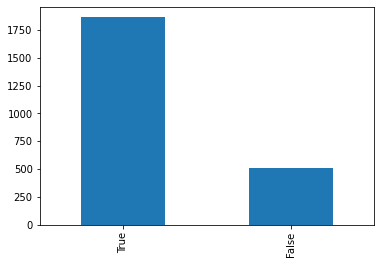

In [35]:
agg_minus_dupes['fromStudy'].value_counts().plot.bar()

<AxesSubplot:>

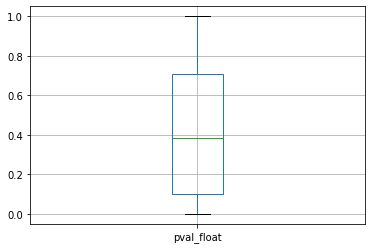

In [36]:
agg_minus_dupes[agg_minus_dupes['pval_float'] > 0].boxplot(column=['pval_float']) # This is starting to look good 




In [37]:
# Let's see what happens if we split off the pain condition
def condition_has_pain(conditions): 
    return True in [('pain' in condition.lower()) for condition in conditions]

agg_minus_dupes['is_pain'] = agg_minus_dupes['conditions'].apply(condition_has_pain)
agg_minus_dupes.head()

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89,True
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94,True
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64,True
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59,True
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52,True


In [38]:
pain_agg = agg_minus_dupes[(agg_minus_dupes['is_pain']) & (agg_minus_dupes['pval_float'] > 0) & (agg_minus_dupes['type'] == 'Primary')]
pain_agg

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.890000,True
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.940000,True
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.640000,True
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.590000,True
7,NCT01977937,Difference in Pain Control When Adding Gabapen...,"[OG000, OG001]",D'Agostino & Pearson normality test was used t...,"t-test, 2 sided",NA,True,0.07,"{'OG000': 'Gabapentin', 'OG001': 'Simple Syrup'}",Gabapentin,NA,Primary,Patients will rate their pain using the Visual...,"[Pain, Postoperative]",0.070000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 16,t-test,Mean,False,0.6014976138086221,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.601498,True
2811,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 17,t-test,Mean,False,0.527201298565683,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.527201,True
2813,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 19,t-test,Mean,False,0.3242055546647684,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.324206,True
2857,NCT01067144,Time to Pain Resolution,"[OG001, OG000]",NA,t-test,Median,False,0.4075835931290681,"{'OG001': 'Gabapentin', 'OG000': 'Control'}",Gabapentin,Control,Primary,Time to pain resolution was defined as 5 conse...,"[Pain, Breast Cancer, Lung Cancer]",0.407584,True


<AxesSubplot:>

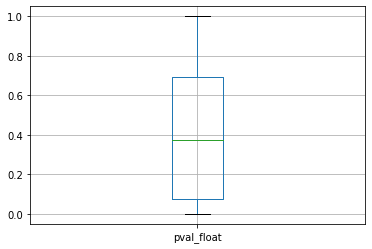

In [39]:
pain_agg.boxplot(column=['pval_float'])

# Looks like this hasn't changed from the aggregates 

<AxesSubplot:xlabel='is_pain', ylabel='pval_float'>

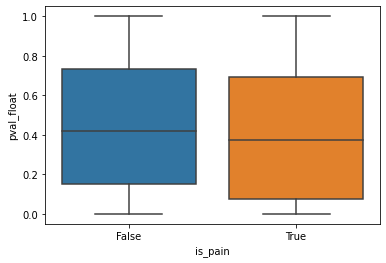

In [40]:
boxie = agg_minus_dupes[(agg_minus_dupes['type'] == 'Primary') & (agg_minus_dupes['pval_float'] > 0)]
sns.boxplot(x='is_pain', y='pval_float', data=boxie)

In [41]:
# A few different things we could look at with these values
# Start looking at what measures are relevant to what condition - this opens up secondary measures 
# Look at the difference between derived and absolute - maybe flag those studies
# Look at the 'purity' of a measure for a drug - see if that measure is only using that drug or something else 
# Start looking at ways to aggregate the doses for analysis
# Start looking at ways to cluster the conditions for similarities
# Start parsing out the side effects 

# I think we need to differentiate between interventions to get purity of a test

In [42]:
# We need the measure description, and both of the groups descriptions

int_aggs = agg_minus_dupes.merge(studies_df[['study_id', 'interventions']], 'left', ['study_id']).rename(columns={
    'interventions':'study_interventions'})
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89,True,[Gabapentin]
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94,True,[Gabapentin]
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64,True,[Gabapentin]
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59,True,[Gabapentin]
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52,True,[Gabapentin]


In [43]:
# Get number of interventions used 

int_aggs['ints_used'] = int_aggs.apply(lambda x: list(filter(lambda y: y.lower() in x.intervention_title.lower(), x.study_interventions)), axis=1)
int_aggs['no_ints_used'] = int_aggs['ints_used'].apply(len)
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89,True,[Gabapentin],[Gabapentin],1
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94,True,[Gabapentin],[Gabapentin],1
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64,True,[Gabapentin],[Gabapentin],1
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59,True,[Gabapentin],[Gabapentin],1
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52,True,[Gabapentin],[Gabapentin],1


<AxesSubplot:>

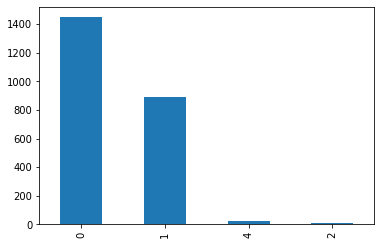

In [44]:
int_aggs['no_ints_used'].value_counts().plot.bar()

In [45]:
int_aggs[int_aggs['no_ints_used'] == 0]

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
14,NCT00475904,Change in Pain Scores Comparing NP-1 Cream vs....,"[OG000, OG002]","In the initial analysis, the efficacy of the t...",ANOVA,Mean Difference (Final Values),True,0.0441,"{'OG000': 'Amitriptyline 4% Ketamine 2% Cream,...",NA,"Amitriptyline 4% Ketamine 2% Cream, Placebo Ca...",Primary,Difference in pain scores between NP-1 cream v...,"[Post Herpetic Neuralgia, PHN, Neuropathy, Ner...",0.044100,True,[Gabapentin],[],0
24,NCT01623271,Visual Analog Scale (VAS) at Visit 3,[OG000],NA,"t-test, 2 sided",NA,True,>0.05,{'OG000': 'CRPS I Pain Subjects'},NA,NA,Primary,Subjects rated their pain using the VAS at vis...,[Complex Regional Pain Syndrome I (CRPS I)],1.000000,True,[Gabapentin],[],0
47,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG000, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,0.0117,"{'OG000': 'G-ER 1200 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.011700,False,[Gabapentin],[],0
48,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG001, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,<0.0001,"{'OG001': 'G-ER 1800 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.000100,False,[Gabapentin],[],0
49,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG000, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,0.1830,"{'OG000': 'G-ER 1200 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.183000,False,[Gabapentin],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,NCT01524796,Change From Baseline In Least Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'},NA,NA,Primary,Pain was assessed on an 11-point NRS where a s...,[Peripheral Neuropathic Pain],0.001000,True,[Pregabalin],[],0
1861,NCT00667342,Mean Ktrans,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The volume transfer constant (Ktrans) was used...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.086300,False,"[Bevacizumab, Doxorubicin, Methotrexate, Etopo...",[],0
1862,NCT00667342,Mean Vp,[OG000],NA,Logistic Regression,NA,True,0.0573,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The fractional blood plasma volume (Vp) was us...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.057300,False,"[Bevacizumab, Doxorubicin, Methotrexate, Etopo...",[],0
1863,NCT00667342,Mean Ve,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The fractional volume of extravascular extrace...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.086300,False,"[Bevacizumab, Doxorubicin, Methotrexate, Etopo...",[],0


Currently looking at about a 20% hit rate for analytics coming from the studies themsevles
This is not good at all considering these are generally assumed to be more accurate though 
they do measure more things than just one drug so high attrition is to be expected

- Note: Over half of those are coming from two studies with no interventions at all so it's not as bas as it seems

<AxesSubplot:>

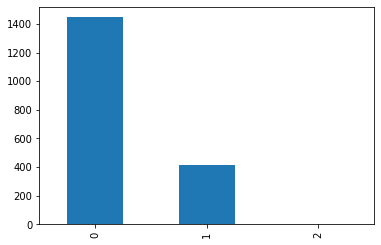

In [46]:
int_aggs[int_aggs['fromStudy']]['no_ints_used'].value_counts().plot.bar()

<AxesSubplot:>

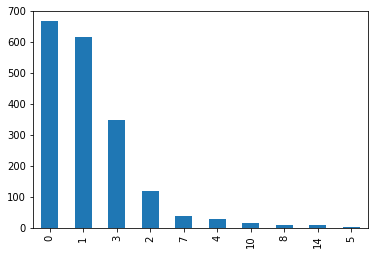

In [47]:
int_aggs[int_aggs['fromStudy']]['study_interventions'].apply(len).value_counts().plot.bar()

# How can a study have 0 interventions???

In [48]:
int_aggs[int_aggs['study_interventions'].apply(len) == 0]['study_id'].value_counts()

NCT03975790    665
NCT00404248      3
Name: study_id, dtype: int64

<AxesSubplot:xlabel='no_ints_used', ylabel='pval_float'>

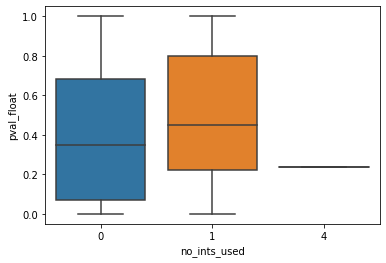

In [49]:
# Let's redo the pain stuff with boxplots
pain_agg = int_aggs[int_aggs['is_pain'] & (int_aggs['pval_float'] > 0) & (int_aggs['type'] == 'Primary')]
sns.boxplot(x='no_ints_used', y='pval_float', data=pain_agg)

Let's see if we can get some decent results this way - only using primaries

- Secondaries should be labeled for this kind of thing to, but our false positive rate is low which is what matters
- Still need to deal with that greater than issue


In [50]:
# Need to break off a few conditions - let's manually group them for now - just take the first one
studies_df['conditions'].apply(lambda x: x[0]).value_counts()[0:10]

Restless Legs Syndrome     7
Postoperative Pain         6
Pain                       5
Epilepsies, Partial        4
Alcohol Dependence         4
Hot Flashes                3
Pain, Postoperative        2
Vulvodynia                 2
Neuralgia, Postherpetic    2
Cannabis Dependence        2
Name: conditions, dtype: int64

In [51]:
int_aggs['conditions'].apply(lambda x: x[0]).value_counts()

Rheumatoid Arthritis                         665
Pain, Neuropathic                            364
Diabetic Neuropathy, Painful                 326
Healthy                                      141
Renal Pelvis Cancer                           80
                                            ... 
Carpal Tunnel Syndrome                         1
Opioid-Induced Hyperalgesia                    1
Vulvar Pain Symptoms                           1
Benzodiazepine Dependence                      1
Complex Regional Pain Syndrome I (CRPS I)      1
Name: conditions, Length: 62, dtype: int64

In [52]:
int_aggs['study_id'].value_counts()

NCT03975790    665
NCT01236053    364
NCT00385671    326
NCT03179345    120
NCT01138124     80
              ... 
NCT00726999      1
NCT00619983      1
NCT01632215      1
NCT01893632      1
NCT00617461      1
Name: study_id, Length: 86, dtype: int64

## Side Affects
Take a look at the adverse affects from each study - this is where drug purity comes in though

Should we just sum up all the adverse affects or only those with the drug in them

#### Data Model
- Need to make the tables first 

In [53]:
groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


In [54]:
# We need to add the event groups to the groups table??
def add_effects_groups(studies):
    df = {
        'study_id': [],
        'id': [],
        'name': [],
        'description': [],
        'participants': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection']['AdverseEventsModule'] #Small risk here
        for group in adverse_module.get('EventGroupList', {'EventGroup': []})['EventGroup']:
            df['study_id'].append(study_id)
            df['id'].append(group.get('EventGroupId', 'NA'))
            df['name'].append(group.get('EventGroupTitle', 'NA'))
            df['description'].append(group.get('EventGroupDescription', 'NA'))
            df['participants'].append(int(group.get('EventGroupOtherNumAtRisk', 0) or group.get('EventGroupDeathsNumAtRisk', 0) or group.get('EventGroupSeriousNumAtRisk', 0)))
    
    return df

total_groups = pd.concat([groups, pd.DataFrame.from_dict(add_effects_groups(studies))])
total_groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


In [55]:
def create_effects_table(studies):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection']['AdverseEventsModule'] #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(EXAMPLE_DRUG)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

effects = pd.DataFrame.from_dict(create_effects_table(studies))
effects       

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold
0,gabapentin,NCT01675960,EG000,Increased sleepiness,other,General disorders,Non-systematic Assessment,1.0,0.0
1,gabapentin,NCT01675960,EG001,Increased sleepiness,other,General disorders,Non-systematic Assessment,0.0,0.0
2,gabapentin,NCT01977937,EG000,Emesis,other,Gastrointestinal disorders,Systematic Assessment,1.0,0.0
3,gabapentin,NCT01977937,EG001,Emesis,other,Gastrointestinal disorders,Systematic Assessment,0.0,0.0
4,gabapentin,NCT02052414,EG000,Extremity swelling,other,Metabolism and nutrition disorders,Systematic Assessment,2.0,0.0
...,...,...,...,...,...,...,...,...,...
3075,gabapentin,NCT00667342,EG001,"Pain, lip",other,General disorders,Non-systematic Assessment,1.0,5.0
3076,gabapentin,NCT00667342,EG000,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,0.0,5.0
3077,gabapentin,NCT00667342,EG001,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,2.0,5.0
3078,gabapentin,NCT00667342,EG000,Infection with normal ANC or Grade 1 or 2 neut...,other,Infections and infestations,Non-systematic Assessment,0.0,5.0


#### Explore Effects
Let's take a look into this brand new world just discovered

In [56]:
# The top few are expected for this drug

effects['effect_name'].value_counts()

Dizziness                               113
Headache                                101
Nausea                                  100
Somnolence                               90
Fatigue                                  74
                                       ... 
Palpitations                              1
Excessive granulation tissue              1
Coughing                                  1
Upper respiratory tract inflammation      1
Gas                                       1
Name: effect_name, Length: 678, dtype: int64

#### Compare to Controls
Let's label which effects came from the drug versus the control to get a good idea

In [57]:
working_effects = effects.merge(total_groups.rename(columns={'id': 'group_id'}), 'left', ['study_id', 'group_id'])
working_effects['is_control'] = working_effects['name'].apply(find_placebo_groups)
working_effects['is_intervention'] = working_effects['name'].apply(find_drug_groups)
working_effects

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_control,is_intervention
0,gabapentin,NCT01675960,EG000,Increased sleepiness,other,General disorders,Non-systematic Assessment,1.0,0.0,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,2,False,True
1,gabapentin,NCT01675960,EG001,Increased sleepiness,other,General disorders,Non-systematic Assessment,0.0,0.0,Placebo,Glycerin based clear solution that is flavored...,2,True,False
2,gabapentin,NCT01977937,EG000,Emesis,other,Gastrointestinal disorders,Systematic Assessment,1.0,0.0,Gabapentin,Gabapentin 15 milligrams per kilogram will be ...,24,False,True
3,gabapentin,NCT01977937,EG001,Emesis,other,Gastrointestinal disorders,Systematic Assessment,0.0,0.0,Simple Syrup,Simple syrup compounded by the Oregon Health a...,26,False,False
4,gabapentin,NCT02052414,EG000,Extremity swelling,other,Metabolism and nutrition disorders,Systematic Assessment,2.0,0.0,Gralise (Gabapentin ER),An Open label trial with Gralise. All subjects...,31,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,gabapentin,NCT00667342,EG001,"Pain, lip",other,General disorders,Non-systematic Assessment,1.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3076,gabapentin,NCT00667342,EG000,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False
3077,gabapentin,NCT00667342,EG001,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,2.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3078,gabapentin,NCT00667342,EG000,Infection with normal ANC or Grade 1 or 2 neut...,other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False


In [58]:
int_sums = {}
def count_effects(effect_name, no_affected, ledger):
    if effect_name not in ledger:
        ledger[effect_name] = 0
    ledger[effect_name] += no_affected

intervention_effects = working_effects[working_effects['is_intervention']]

intervention_effects.apply(lambda x: count_effects(x.effect_name, x.no_effected, int_sums), axis=1)
int_effect_sums = pd.Series(int_sums).sort_values(ascending=False)
int_effect_sums

Dizziness              392.0
Somnolence             382.0
Headache               276.0
Nausea                 235.0
Dry mouth              207.0
                       ...  
Pulmonary effusion       0.0
Pulmonary edema          0.0
Pharyngeal leak          0.0
Oxygen desaturation      0.0
Hypoparathyroidism       0.0
Length: 435, dtype: float64

In [59]:
# Now the controls 
cont_sums = {}
working_effects[working_effects['is_control']].apply(lambda x: count_effects(x.effect_name, x.no_effected, cont_sums), axis=1)
cont_effect_sums = pd.Series(cont_sums).sort_values(ascending=False)
cont_effect_sums

Headache                          237.0
Nausea                            221.0
Dry mouth                         196.0
Dizziness                         191.0
Constipation                      176.0
                                  ...  
Parasthesia (right foot)            0.0
Oropharyngeal bleeding              0.0
Oral wound dehiscence               0.0
Myasthenia gravis exacerbation      0.0
Increased sleepiness                0.0
Length: 345, dtype: float64

<AxesSubplot:>

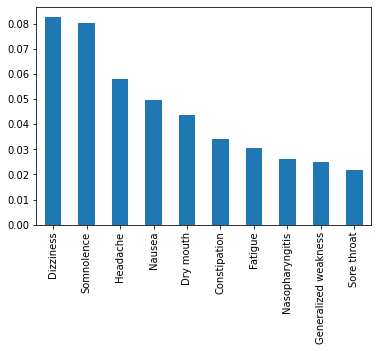

In [60]:
# Get the percentages 
total_at_risk = working_effects[working_effects['is_intervention']].drop_duplicates(['study_id'])['participants'].sum()
percent_effects = {k: (v/total_at_risk) for (k,v) in int_sums.items()}
pd.Series(percent_effects).sort_values(ascending=False)[0:10].plot.bar()


### Clustering 
There are a lot of similar conditions and side effects that should be considered as one

Not expercting a full blown system or model as might be reuqired, but maybe some basic edit distance clustering 
would help

We could also take a look wordnet to find synonyms here - might be better than a medical dictionary, though wordnet might be quite large 

Perhaps removing the adjectives in the conditions would help as well - jsut get the noun

In [61]:
# Edit distance implementation: https://stackoverflow.com/questions/2460177/edit-distance-in-python

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [71]:
# Git a list of all the conditions 
conditions = pd.Series([c for cs in studies_df['conditions'].tolist() for c in cs ])


In [73]:
# Cluster by distance to see what similar means 
# We will try: heirarchical, affinity, and maybe some graph based 
# First heirarchical 

# Edit distance is a terrible meausre since we're clustering by medical terms 
from sklearn.cluster import AffinityPropagation

words = conditions.tolist()
words = np.asarray(words) #So that indexing with a list will work
def affinity_cluster(words, distance):
    lev_similarity = -1*np.array([[distance(w1,w2) for w1 in words] for w2 in words])

    affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
    affprop.fit(lev_similarity)
    for cluster_id in np.unique(affprop.labels_):
        exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
        cluster_str = ", ".join(cluster)
        print(" - *%s:* %s" % (exemplar, cluster_str))
        
affinity_cluster(words, levenshteinDistance) # Didn't fucking work at all!

 - *Signs and Symptoms, Digestive:* Signs and Symptoms, Digestive
 - *Pain, Postoperative:* Pain, Intractable, Pain, Postoperative
 - *Benzodiazepine Dependence:* Benzodiazepine Dependence
 - *Opioid Use:* Blood Pressure, Obesity, Morbid, Opioid Use, Tobacco Use
 - *Hospital Length of Stay:* Hospital Length of Stay
 - *Alcohol Dependence:* Abortion, Induced, Alcohol Dependence, Cannabis Dependence, Cocaine Dependence, Opioid Dependence, Vasomotor Disturbance
 - *Aneurysmal Subarachnoid Hemorrhage:* Aneurysmal Subarachnoid Hemorrhage
 - *Neuropathy:* Burn Injury, Facial Neuropathy, Menopause, Neuropathy, Pain, Neuropathic, Polyneuropathies, Radiculopathy
 - *Spontaneous Abortion:* Cisplatin Adverse Reaction, Conscious Sedation, Opioid Detoxification, Other Abortion, Spontaneous Abortion
 - *Vulvodynia (Chronic Vulvar Pain):* Vulvodynia (Chronic Vulvar Pain)
 - *Postoperative Pain:* Posterior Spine Surgery, Postoperative Delirium, Postoperative Nausea and Vomiting, Postoperative Pain
 - 

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


<AxesSubplot:>

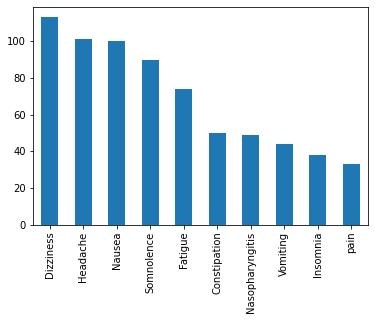

In [122]:
# Let's just try taking out the adjective
def trim_effect(effect):
    tokens = nltk.word_tokenize(effect)
    pos = nltk.pos_tag(tokens)
    
    return '-'.join([x[0] for x in pos if ('n' == x[1][0].lower() or 'v' == x[1][0].lower())])

# 
working_effects['effect_name'].apply(trim_effect).value_counts()[0:10].plot.bar()

<AxesSubplot:>

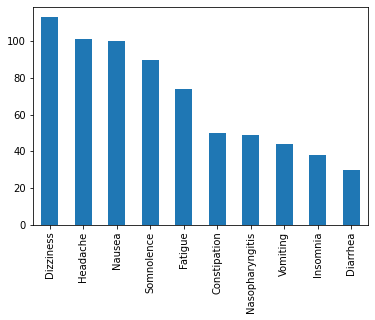

In [123]:
working_effects['effect_name'].value_counts()[0:10].plot.bar()

Looks like from trials the "safest" method for clustering these is:
 - Make sure all the words are tokenized and lower case 
 - Cluster words that are direct synonyms i.e. in the word net 
 - Cluster very similar words that are study-disjoint: TODO 
 
This is all so that we get a low false postive rate that is accurate to the studies 

In [ ]:
# Loop through effects: add to new affect if above conditions are met
def is_same_effect(effectA, effectB)
    if len(effectA.split(' ')) != len(effectB.split(' ')):
        return False
    
    set1 = wn.synsets(effectA.lower())
    set2 = wn.synsets(effectB.lower())
    
    return set1[0].wup_similarity(set2[0])
    
def aggregate_effects(effects):
    for k1 in effects.values():
        for (k2, v) in effects.items():
            lk1 = k1.lower()
            lk2 = k2.lower()
            if is_same_effect(lv1, lv2) and k1 != k2:
                effects[lk1] 
                
                

In [98]:
# Let's cluster the effects by snynonyms using the word net

from nltk.corpus import wordnet as wn

def medical_distance(effectA, effectB): # Between 0 and 1
    set1 = wn.synsets(effectA.lower())
    set2 = wn.synsets(effectB.lower())
    
    
    
    if not set1 or not set2:
        return 10
    
    w1 = set1[0]
    w2 = set2[0]
    sim = w1.wup_similarity(w2) if w1.wup_similarity(w2) else 0
    return (10 - int(10*sim)) * -1


words = np.array(working_effects['effect_name'].value_counts().keys().tolist())
affinity_cluster(words, medical_distance)


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


IndexError: list index out of range

In [76]:
wn.synsets('somnolence')

[Synset('sleepiness.n.01')]

In [77]:
wn.synsets('fatigue')

[Synset('fatigue.n.01'),
 Synset('fatigue.n.02'),
 Synset('fatigue.n.03'),
 Synset('fatigue_duty.n.01'),
 Synset('tire.v.01'),
 Synset('tire.v.02')]

In [78]:
wn.synsets('sleepiness')

[Synset('sleepiness.n.01')]

In [79]:
wn.synsets('nausea')

[Synset('nausea.n.01'), Synset('nausea.n.02')]

In [104]:
w1 = wn.synset('sleepiness.n.01')
w2 = wn.synset('tiredness.n.01')

w1.wup_similarity(w2)

0.8333333333333334